__Lab 05 - SCA (Part 2): Timing Attack__

Student Names: [Jwala Sri Hari Badam & Ganesh Veluru]

Group Number: [3]

# Setup

## Importing Python Libraries & Setup ChipWhisperer

Begin by importing the required libraries, connecting to the scope, and applying the default setup:

In [670]:
%matplotlib notebook
import matplotlib.pyplot as plt
import chipwhisperer as cw
import numpy as np
import scipy.stats
from tqdm import tnrange

Next, compile the firmware:

In [671]:
# This is an API for your CW's scope (in the CAPTURE section)
scope = cw.scope()

# This is an API for your CW's target (in the TARGET section)
target = cw.target(scope, cw.targets.SimpleSerial)

# Sets the scope's default settings
scope.default_setup()

# Cap the max num of power trace samples to collect
scope.adc.samples = 500

# Prints the scope settings
print(scope)

print("✔️ OK to continue!")

Serial baud rate = 38400
ChipWhisperer Nano Device
fw_version = 
    major = 0
    minor = 62
    debug = 0
io = 
    tio1         = None
    tio2         = None
    tio3         = None
    tio4         = None
    pdid         = True
    pdic         = False
    nrst         = True
    clkout       = 7500000.0
    cdc_settings = array('B', [1, 0])
adc = 
    clk_src  = int
    clk_freq = 7500000.0
    samples  = 500
glitch = 
    repeat     = 0
    ext_offset = 0

✔️ OK to continue!


Program the microcontroller with the "training-CWNANO" hex file:

In [672]:
%%bash
cd ../Firmware
make PLATFORM=CWNANO CRYPTO_TARGET=NONE

SS_VER set to SS_VER_1_1
make clean_objs .dep 
make[1]: Entering directory '/home/phs/Desktop/phs-labs/PHS-Lab-05/Firmware'
SS_VER set to SS_VER_1_1

+--------------------------------------------------------

Removing old files
rm -f -- training-CWNANO.hex
rm -f -- training-CWNANO.elf
rm -f -- training-CWNANO.map
rm -f -- objdir-CWNANO/*.o
rm -f -- objdir-CWNANO/*.lst
rm -f -- training.s simpleserial.s stm32f0_hal_nano.s stm32f0_hal_lowlevel.s
rm -f -- training.d simpleserial.d stm32f0_hal_nano.d stm32f0_hal_lowlevel.d
rm -f -- training.i simpleserial.i stm32f0_hal_nano.i stm32f0_hal_lowlevel.i
make[1]: '.dep' is up to date.
make[1]: Leaving directory '/home/phs/Desktop/phs-labs/PHS-Lab-05/Firmware'
make begin gccversion build sizeafter
make[1]: Entering directory '/home/phs/Desktop/phs-labs/PHS-Lab-05/Firmware'
SS_VER set to SS_VER_1_1

+--------------------------------------------------------

Welcome to another exciting ChipWhisperer target build!!


arm-none-eabi-gcc (15:10.3-2021.

+--------------------------------------------------------
+ Output File: training-CWNANO.hex
+--------------------------------------------------------
make[1]: Leaving directory '/home/phs/Desktop/phs-labs/PHS-Lab-05/Firmware'


In [673]:
prog = cw.programmers.STM32FProgrammer
fw_path = '../Firmware/training-CWNANO.hex'
cw.program_target(scope, prog, fw_path)

print("✔️ OK to continue!")

Serial baud rate = 115200
Detected known STMF32: STM32F04xxx
Extended erase (0x44), this can take ten seconds or more
Attempting to program 13867 bytes at 0x8000000
STM32F Programming flash...
STM32F Reading flash...
Verified flash OK, 13867 bytes
Serial baud rate = 38400
✔️ OK to continue!


## Creating Functions to Reset & Read Target

These functions allow you to reset the target from your code and read any text received from the device:

__These functions are completed, no need to change__

In [674]:
import time
def reset_target(): 
    target.flush()
    scope.io.nrst = 'low'
    time.sleep(0.2)
    scope.io.nrst = 'high'
    time.sleep(0.01)

def readall_target():
    ret = ""
    num_char = target.in_waiting()
    while num_char > 0:
        ret += target.read(timeout=10)
        time.sleep(0.1)
        num_char = target.in_waiting()
    return ret

print("✔️ OK to continue!")

✔️ OK to continue!


Call those two functions here (print the output of readall_target())

In [675]:
# Should print start-up test from the device
reset_target()
print(readall_target())
print("✔️ OK to continue!")

*****Safe-o-matic 3000 Booting...
Aligning bits........[DONE]
Checking Cesium RNG..[DONE]
Masquerading flash...[DONE]
Decrypting database..[DONE]


Please enter password to continue: 
✔️ OK to continue!


# Testing Target w/Example Password

This functions allow you to write (i.e., send) a password to the device and read back the result.

Note: There are 2 different (but similar) versions of the password checker: `password_checker_v1` and `password_checker_v2`. Use "cmd" to select the version of the password checker function: 'a' for v1 and 'b' for v2.

__This function is completed, no need to change__

In [676]:
# Function: get_pwr_trace()
#   Input:  'password_guess' - input string of max 16 characters (it also accepts shorter strings)
#   Input:  'cmd'            - input character command to select the respective function from the CW
#   Output: 'msg'            - returns "ACCESS GRANTED" if correct password, otherwise "WRONG PASSWORD"
def check_password(password_guess, cmd='a'):
    # reset target and read start-up text
    reset_target()
    # print(readall_target()) # use this to print the start-up text
    readall_target() # use this to not print the start-up text

    # encode password as bytes
    # then append 0s at the end because it expects 16 bytes

    b = bytearray(password_guess.encode())
    if(16-len(b) < 0):
        return
    b += bytes(16 - len(b))  

    # send the encoded password
    target.simpleserial_write(cmd, b)
    time.sleep(0.01)

    # reads output text from device
    # Note: [:-4] removes the last 4 char added extra by the target, which are useless.
    msg = readall_target()[:-4]
    return msg
    
print("✔️ OK to continue!")

✔️ OK to continue!


Here is an example of resetting the target, writing a password to the device, and reading back the result.

For the training file, the correct password is "USFCSE".

__These code cells are completed, no need to change__

In [677]:
password = "USFCSE"

msg = check_password(password, 'a')

print(msg)

# do not change these lines below:
assert msg == "ACCESS GRANTED"
print("✔️ OK to continue!")

ACCESS GRANTED
✔️ OK to continue!


In [678]:
password = "BadPassword"

msg = check_password(password, 'a')

print(msg)

# do not change these lines below:
assert msg == "WRONG PASSWORD"
print("✔️ OK to continue!")

WRONG PASSWORD
✔️ OK to continue!


# Recording Traces

Now that we can communicate with our super-secure system, our next goal is to get a power trace while the target is running. To do this, we'll arm the scope just before we send our password attempt, then record the trace as we've done before.

In [679]:
# You may decrease this for faster speed. But IF too small power sample size, 
# then you may not collect the last part of the running firmware on the CW.

scope.adc.samples = 800
print("✔️ OK to continue!")

✔️ OK to continue!


First we'll make a function to guess a password and return a power trace, since we'll be repeating those steps a lot.

Note: There are 2 different (but similar) versions of the password checker: password_checker_v1 and password_checker_v2. Use "cmd" to select the version of the password checker function: 'a' for v1 and 'b' for v2.

__This function is completed, no need to change__

In [680]:
# Function: get_pwr_trace()
#   Input:  'password_guess' - input string of max 16 characters (it also accepts shorter strings)
#   Input:  'cmd'            - input character command to select the respective function from the CW
#   Output: 'trace'          - power trace collected from the CW as a Numpy Array
def get_pwr_trace(password_guess, cmd):
    # reset target and read start-up text
    reset_target()
    # print(readall_target()) # use this to print the start-up text
    readall_target() # use this to not print the start-up text

    scope.arm()

    b = bytearray(password_guess.encode())
    if 16-len(b)<0:
        return
    b += bytes(16 - len(b))
    target.simpleserial_write(cmd, b)

    ret = scope.capture()
    if ret:
        print('Timeout happened during acquisition')

    trace = scope.get_last_trace()
    return trace

print("✔️ OK to continue!")

✔️ OK to continue!


Test this function:

__Complete missing parts__

In [682]:
password = "USFCSE"
trace = get_pwr_trace(password, 'a')

print(trace)

# do not change these lines below:
assert type(trace) == np.ndarray
assert len(trace)  > 0
print("✔️ OK to continue!")

[ 0.03515625  0.08984375  0.02734375 -0.24609375  0.05078125  0.08203125
 -0.0625     -0.25390625 -0.23046875 -0.2421875  -0.00390625  0.10546875
 -0.01953125  0.0546875   0.00390625 -0.23046875  0.10546875  0.05859375
 -0.18359375  0.08984375  0.00390625  0.05078125 -0.0078125   0.11328125
  0.          0.03515625 -0.01171875 -0.2421875   0.08984375  0.05078125
 -0.19140625  0.08984375 -0.00390625  0.0390625  -0.01953125  0.08984375
 -0.01953125  0.02734375 -0.015625   -0.25        0.08984375  0.046875
 -0.19921875  0.078125   -0.0078125   0.03515625 -0.01953125  0.08984375
 -0.01953125  0.015625   -0.03125    -0.2578125   0.078125    0.05078125
 -0.19921875  0.078125   -0.01171875  0.02734375 -0.03125     0.08984375
 -0.01953125  0.015625   -0.02734375 -0.26171875  0.05859375  0.01953125
 -0.21484375  0.06640625 -0.01171875  0.02734375 -0.03515625  0.08203125
 -0.02734375  0.00390625 -0.03515625 -0.26953125  0.06640625  0.01953125
 -0.21484375  0.05078125 -0.0234375   0.01953125 -0.0

# Timing Analysis - Generate & Plot Traces

Now that we can generate traces for any given passwords, then we can try to analyze the power consumption and figure out how to use this information to find the password. But just 1 plot might not be enough (as you can see from previous example). We need to compare an contrast different power examples.

## Test 1: Plot multiple traces for passwords with varying number of correct letters

There are many ways we can attempt to analyze and compare the powers, but we need to start from somewhere.

Since we want to detect the power difference between different passwords, lets collect and plot multiple traces with slight variations: 0, 1, 2, 3, 4, 5, and 6 correct characters. Does this give you any more information on how to attack?

In [683]:
password0 = "xxxxxx"
password1 = "Uxxxxx"
password2 = "USxxxx"
password3 = "USFxxx"
password4 = "USFCxx"
password5 = "USFCSx"
password6 = "USFCSE"

trace0 = get_pwr_trace(password0, 'a')
trace1 = get_pwr_trace(password1, 'a')
trace2 = get_pwr_trace(password2, 'a')
trace3 = get_pwr_trace(password3, 'a')
trace4 = get_pwr_trace(password4, 'a')
trace5 = get_pwr_trace(password5, 'a')
trace6 = get_pwr_trace(password6, 'a')

<IPython.core.display.Javascript object>


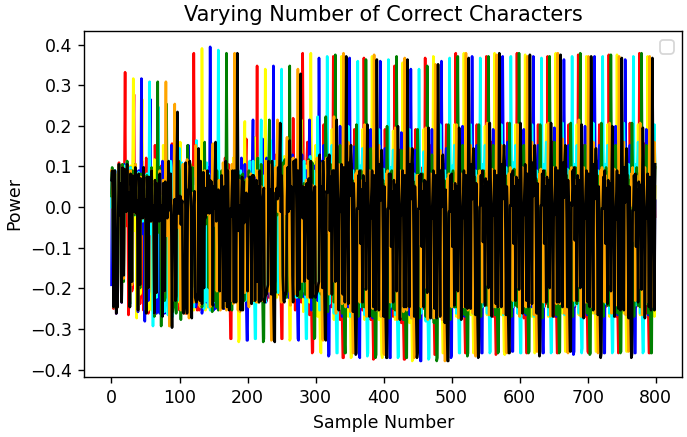

In [684]:
plt.figure(figsize=(5.5, 3.5), constrained_layout=True)

plt.plot(trace0, color="red")
plt.plot(trace1, color="yellow")
plt.plot(trace2, color="blue")
plt.plot(trace3, color="aqua")
plt.plot(trace4, color="green")
plt.plot(trace5, color="orange")
plt.plot(trace6, color="black")

plt.title("Varying Number of Correct Characters")     
plt.xlabel("Sample Number")  # adds x-axis label
plt.ylabel("Power")          # adds y-axis label
plt.legend()

# saves the plot
plt.savefig("../Figures/multiple_trace.pdf")

# show the plot on your screen
plt.show()

## Test 2: Plot difference between traces of varying number of correct letters

It is hard to distinguish each graph. So, let's try instead plotting the differences between each trace. Does this give you any more information on how to attack?

In [685]:
diff_trace = trace0 - trace1 - trace2 - trace3 - trace4 - trace5 - trace6
diff_trace_1 =  trace5 - trace6
diff_trace_2 =  trace6 - trace0

<IPython.core.display.Javascript object>


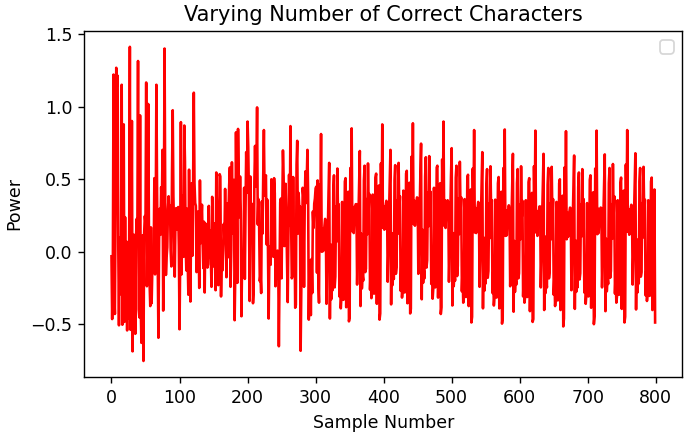

In [686]:
plt.figure(figsize=(5.5, 3.5), constrained_layout=True)

plt.plot(diff_trace, color="red")

plt.title("Varying Number of Correct Characters")     
plt.xlabel("Sample Number")  # adds x-axis label
plt.ylabel("Power")          # adds y-axis label
plt.legend()

# saves the plot
plt.savefig("../Figures/diff_trace_plot.pdf")

# show the plot on your screen
plt.show()

<IPython.core.display.Javascript object>


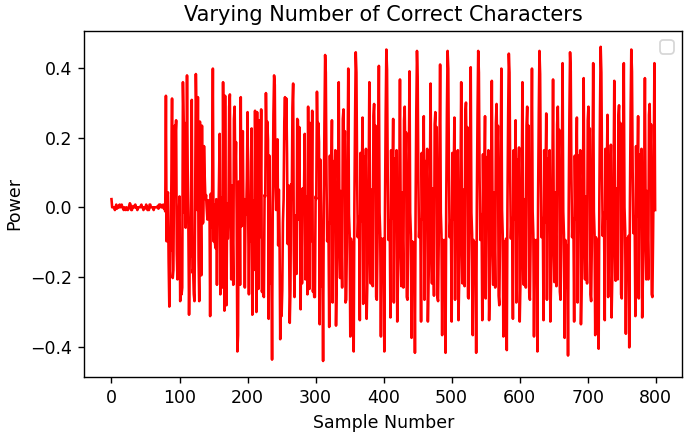

In [687]:
#diff_trace_1 =  trace5 - trace6

plt.figure(figsize=(5.5, 3.5), constrained_layout=True)

plt.plot(diff_trace_1, color="red")

plt.title("Varying Number of Correct Characters")     
plt.xlabel("Sample Number")  # adds x-axis label
plt.ylabel("Power")          # adds y-axis label
plt.legend()

# saves the plot
plt.savefig("../Figures/diff_trace_plot_1.pdf")

# show the plot on your screen
plt.show()

<IPython.core.display.Javascript object>


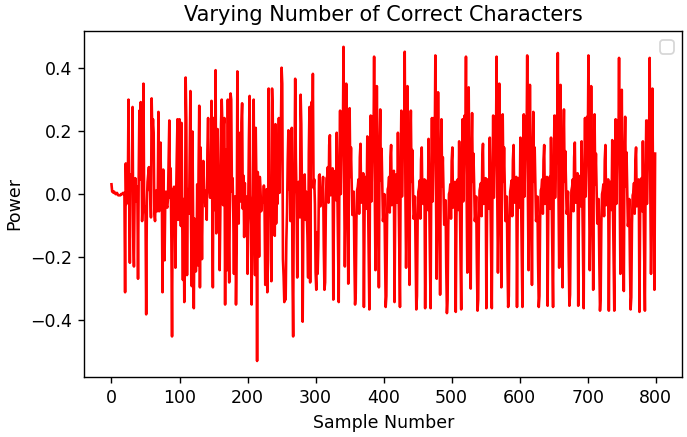

In [688]:
#diff_trace_2 =  trace6 - trace0

plt.figure(figsize=(5.5, 3.5), constrained_layout=True)

plt.plot(diff_trace_2, color="red")

plt.title("Varying Number of Correct Characters")     
plt.xlabel("Sample Number")  # adds x-axis label
plt.ylabel("Power")          # adds y-axis label
plt.legend()

# saves the plot
plt.savefig("../Figures/diff_trace_plot_2.pdf")

# show the plot on your screen
plt.show()

## Test 3: Plot traces for passwords with same vs different number of correct letters

Try between traces with same number of correct characters (e.g., 3 correct) vs finding an additional correct character. Does this give you any more information on how to attack?

In [703]:
password0 = "U"
password1 = "US"

trace0 = get_pwr_trace(password0, 'a')
trace1 = get_pwr_trace(password1, 'a')

<IPython.core.display.Javascript object>


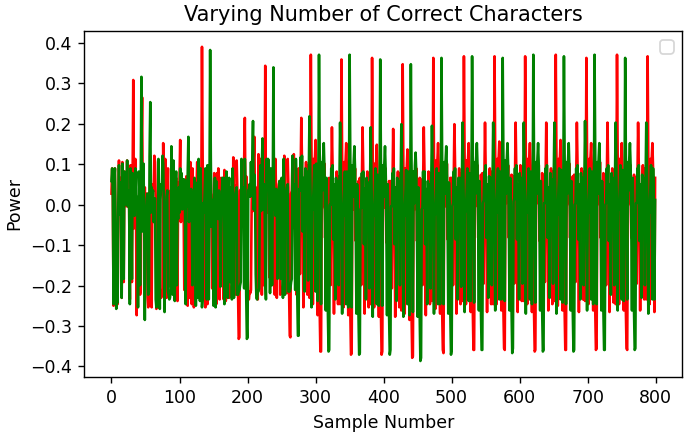

In [704]:
plt.figure(figsize=(5.5, 3.5), constrained_layout=True)

plt.plot(trace0, color="red")
plt.plot(trace1, color="green")

plt.title("Varying Number of Correct Characters")     
plt.xlabel("Sample Number")  # adds x-axis label
plt.ylabel("Power")          # adds y-axis label
plt.legend()

# saves the plot
plt.savefig("../Figures/one_two_crctletters.pdf")

# show the plot on your screen
plt.show()

In [705]:
password0 = "USF"
password1 = "USFB"

trace0 = get_pwr_trace(password0, 'a')
trace1 = get_pwr_trace(password1, 'a')

<IPython.core.display.Javascript object>


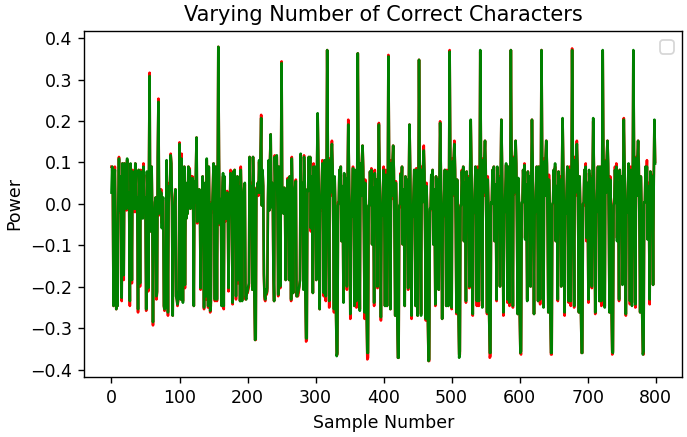

In [706]:
plt.figure(figsize=(5.5, 3.5), constrained_layout=True)

plt.plot(trace0, color="red")
plt.plot(trace1, color="green")

plt.title("Varying Number of Correct Characters")     
plt.xlabel("Sample Number")  # adds x-axis label
plt.ylabel("Power")          # adds y-axis label
plt.legend()

# saves the plot
plt.savefig("../Figures/three_four_crctletters.pdf")

# show the plot on your screen
plt.show()

Base on the previous plots, can you figure out any information leak? Can you infer any hypothesis on how to attack the password checkers?

If so, us this information for your attack!

# Attacking a Single Letter

Now that we've located a distinctive timing difference, we can start building our attack. We'll start with a single letter, since that will quickly give us some feedback on the attack.

The plan for the attack is simple: keep guessing letters until we no longer see the distinctive power traces. To do this, we'll create a loop that:

* Figures out our next character guess
* Does the capture and records the trace
* Checks if the new trace significantly differs or not from a previous (reference) trace.

Assume the password only accepts English alphabetical letter (both uppercase and lowercase).

Since we are going to need specify this criteria many time, let's make a list of char called `char_list` that contains all possible  password characters accepted by the system. This will make it easier for following steps:

__Complete missing parts__

In [707]:
char_list = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N',
            'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c',
             'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 
             'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


First, to make things a little easier for later, we'll make a function that will compare whether our power traces are (guess incorrect) or aren't (guess correct) very similar.

If they are not similar (guess incorrect), then return the approximate position (sample number) where the difference starts. Otherwise, return "False" (boolean).

__Complete missing parts__

In [708]:
# Function: comp_traces()
#   Input:  'trace1' - input power trace 1
#   Input:  'trace2' - input power trace 2
#   Output: 'pos'    - If they are not similar (guess incorrect), then return the approximate 
#                      position (sample number) where the difference starts. 
#                      Otherwise, return "False" (boolean).
def comp_traces(trace1: np.ndarray, trace2: np.ndarray):
    for i in range(len(trace1)):
        if(abs(trace1[i] - trace2[i]) >= 0.2):
            pos = i
            return i
    return False

Test your function:

__These code cells are completed, no need to change__

In [709]:
# Test function 1:
trace_1correct = get_pwr_trace("USxxxxx", 'a')
trace_2correct = get_pwr_trace("USFxxx", 'a')
assert(comp_traces(trace_1correct, trace_2correct) != False)
print("✔️ OK to continue!")

✔️ OK to continue!


In [710]:
# Test function 2:
trace_3correct_v1 = get_pwr_trace("USFxxx", 'a')
trace_3correct_v2 = get_pwr_trace("USFabc", 'a')
assert(comp_traces(trace_3correct_v1, trace_3correct_v2) == False)
print("✔️ OK to continue!")

✔️ OK to continue!


Now, create a function that will find the next correct character (if any) for a given reference password (ref_passwd). If it found the next correct character, then return:
* the next correct character,
* the respective power trace for the password tested with the next correct password,
* and the approximate position (pos) where this trace first differs the trace of the reference password

Note: There are 2 different (but similar) versions of the password checker: password_checker_v1 and password_checker_v2. Use "cmd" to select the version of the password checker function: 'a' for v1 and 'b' for v2.

__Complete missing parts__

In [711]:
# Function: find_letter()
#   Input:  'ref_password' - input reference password to find the next correct character
#   Input:  'cmd'          - input character command to select the respective function from the CW
#   Input:  'char_list'    - input character list of possible allowed char in the password
#   Output: 'ch'           - next correct character. 
#   Output: 'trace_test'   - the respective power trace for the password tested with the next correct password. 
#   Output: 'pos'          - approximate position (sample number) where the difference starts. 
def find_letter(ref_password: str, cmd: str, char_list=char_list):
    x = 0
    for l in char_list:
        ref_trace = get_pwr_trace(ref_password, cmd)
        new_trace = get_pwr_trace(ref_password + l, cmd)
        
        if new_trace is None:
            ch = False
            trace_test = False
            pos = False
            break
            
        check = comp_traces(ref_trace,new_trace)
        if(check == False): 
            if(x <= 50):
                x += 1
                continue
            else:
                ch = False
                trace_test = False
                pos = False
                break
        else:
            if(x > 52):
                ch = False
                trace_test = False
                pos = False
                break
            else:
                ch = l
                trace_test = new_trace
                pos = check
                break

            
    return ch, trace_test, pos

## Test code with training hex file: "training-CWNANO.hex"

Since this is not the full password attack, then just test with cmd='a'

We are giving you 4 test functions for you to try:

__These code cells are completed, no need to change__

In [387]:
# Test function 1:
ch, trace, pos = find_letter("", 'a', char_list)
print(f"ch = {ch}; pos = {pos}")
assert(ch == 'U')
print("✔️ OK to continue!")

ch = U; pos = 20
✔️ OK to continue!


In [75]:
# Test function 2:
ch, trace, pos = find_letter("U", 'a', char_list)
print(f"ch = {ch}; pos = {pos}")
assert(ch == 'S')
print("✔️ OK to continue!")

ch = S; pos = 32
✔️ OK to continue!


In [76]:
# Test function 3:
ch, trace, pos = find_letter("USF", 'a', char_list)
print(f"ch = {ch}; pos = {pos}")
assert(ch == 'C')
print("✔️ OK to continue!")

ch = C; pos = 56
✔️ OK to continue!


In [77]:
# Test function 4:
ch, trace, pos = find_letter("USFCS", 'a', char_list)
print(f"ch = {ch}; pos = {pos}")
assert(ch == 'E')
print("✔️ OK to continue!")

ch = E; pos = 80
✔️ OK to continue!


# Attacking the Full Password

Now that we can guess a single character, attacking the rest is easy. We just need to repeat the process in another loop, and update our password guess (passwd_guess) with the new correct char. You should start with an empty string as your initial reference password to then find the first correct character.

For each time you find a new correct character:
* print this correct character found,
* save the respective trace in a list (trace_list),
* and save the respective approximate positions where it first differs in another list (pos_list)

Once you found all the correct characters, then return
* the complete "passwd_guess",
* the "trace_list",
* and the "pos_list"

After updating the below script and running it, you should see parts of the password printed out as each letter is found.

Note: There are 2 different (but similar) versions of the password checker: password_checker_v1 and password_checker_v2. Use "cmd" to select the version of the password checker function: 'a' for v1 and 'b' for v2.

__Complete missing parts__

In [713]:
# Function: comp_traces()
#   Input:  'cmd'            - input character command to select the respective function from the CW
#   Input:  'char_list'      - input character list of possible allowed char in the password
#   Output: 'password_guess' - final password guess with all the correct characters 
#   Output: 'trace_list'     - list of power traces for each correct substring password
#   Output: 'pos_lits'       - list of approximate position (sample number) where the difference starts  
def find_password(cmd: str, char_list=char_list):
    trace_list=[]
    pos_list=[]
    password_guess=""
    while(True):
        ch, trace, pos = find_letter(password_guess, cmd , char_list)
        if ch==False:
            break
        else:
            trace_list.append(trace)
            pos_list.append(pos)
            password_guess+=ch
            
            
    return password_guess, trace_list, pos_list

## Test code with training hex file: "training-CWNANO.hex"

### Test with cmd='a'

Find the password with `password_checker_v1`

__Complete missing parts__

In [715]:
# "training-CWNANO.hex"; cmd='a'
password, trace_list, pos_list = find_password('a')

print("Password:", password)

# Verify password
msg = check_password(password,'a')
print(f"Confirm {password}: {msg}")

# do not change these lines below:
assert msg == "ACCESS GRANTED"
print("✔️ OK to continue!")

Password: USFCSE
Confirm USFCSE: ACCESS GRANTED
✔️ OK to continue!


Plot all the traces stored in "trace_list" and annotate where each trace starts to differ or with significant peaks (use "pos_list")

<IPython.core.display.Javascript object>


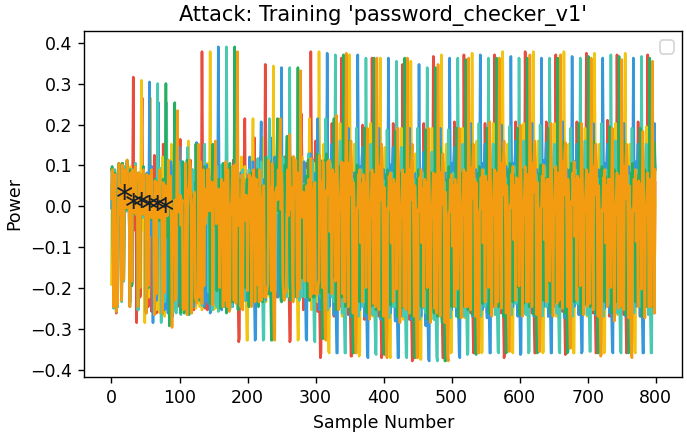

In [716]:
plt.figure(figsize=(5.5, 3.5), constrained_layout=True)

# list for colors
rbg = ['#E74C3C', '#F1C40F', '#3498DB', '#48C9B0', '#27AE60', '#F39C12']

plt.title("Attack: Training 'password_checker_v1'")     
plt.xlabel("Sample Number")  # adds x-axis label
plt.ylabel("Power")          # adds y-axis label
plt.yticks(np.arange(-1.0 - 1, 1.0 + 1, step=0.1))
plt.legend()

for i in range(len(trace_list)):
    plt.plot(trace_list[i], color=rbg[i])
    
x = 0
for trace in trace_list:
    plt.annotate('*', 
                 xy = (pos_list[x], trace[pos_list[x]]), 
                 xytext = (pos_list[x], trace[pos_list[x]]),
                 size=20,
                 color='#17202A',
                 ha='center', va="center")
    x = x + 1
    


# saves the plot
plt.savefig("../Figures/train_cmd_a.pdf")

# show the plot on your screen
plt.show()

### Test with cmd='b'

Find the password with `password_checker_v2`

__Complete missing parts__

In [717]:
# "training-CWNANO.hex"; cmd='b'
password, trace_list, pos_list = find_password('b')

print("Password:", password)

# Verify password
msg = check_password(password,'b')
print(f"Confirm {password}: {msg}")

# do not change these lines below:
assert msg == "ACCESS GRANTED"
print("✔️ OK to continue!")

Password: USFCSE
Confirm USFCSE: ACCESS GRANTED
✔️ OK to continue!


Plot all the traces stored in "trace_list" and annotate where each trace starts to differ or with significant peaks (use "pos_list")

<IPython.core.display.Javascript object>


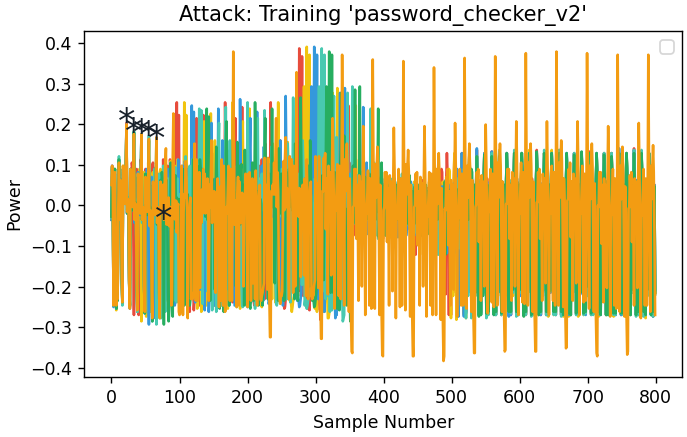

In [718]:
plt.figure(figsize=(5.5, 3.5), constrained_layout=True)

# list for colors
rbg = ['#E74C3C', '#F1C40F', '#3498DB', '#48C9B0', '#27AE60', '#F39C12']

plt.title("Attack: Training 'password_checker_v2'")     
plt.xlabel("Sample Number")  # adds x-axis label
plt.ylabel("Power")          # adds y-axis label
plt.yticks(np.arange(-1.0 - 1, 1.0 + 1, step=0.1))
plt.legend()

for i in range(len(trace_list)):
    plt.plot(trace_list[i], color=rbg[i])
    
x = 0
for trace in trace_list:
    plt.annotate('*', 
                 xy = (pos_list[x], trace[pos_list[x]]), 
                 xytext = (pos_list[x], trace[pos_list[x]]),
                 size=20,
                 color='#17202A',
                 ha='center', va="center")
    x = x + 1
    


# saves the plot
plt.savefig("../Figures/train_cmd_b.pdf")

# show the plot on your screen
plt.show()

# Attacking a Secret Password

After you verified your code correct functionality with the training file, now re-use the same code to find the secret password in the "attack-CWNANO.hex" file. Notice that we have not given you the ".c" file, so you do not know the password.

Note: "attack-CWNANO.hex" is the same code as "training-CWNANO.hex" but with a different secret password that you need to find. If you implemented previous steps and functions correctly, you should not have any issues 

Run this code to program the ChipWhisperer's microcontroller with the attack hex file:

__This code cell is completed, no need to change__

In [761]:
prog = cw.programmers.STM32FProgrammer
fw_path = '../Firmware/attack-CWNANO.hex'
cw.program_target(scope, prog, fw_path)

Serial baud rate = 115200
Detected known STMF32: STM32F04xxx
Extended erase (0x44), this can take ten seconds or more
Attempting to program 13783 bytes at 0x8000000
STM32F Programming flash...
STM32F Reading flash...
Verified flash OK, 13783 bytes
Serial baud rate = 38400


## Test code with arrack hex file: "attack-CWNANO.hex"

### Test with cmd='a'

Find the password with `password_checker_v1`

__Complete missing parts__

In [723]:
# "attack-CWNANO.hex"; cmd='a'
password, trace_list, pos_list = find_password('a')

print("Password:", password)

# Verify password
msg = check_password(password,'a')
print(f"Confirm {password}: {msg}")

# do not change these lines below:
assert msg == "ACCESS GRANTED"
print("✔️ OK to continue!")

Password: TimingSCAgzt
Confirm TimingSCAgzt: ACCESS GRANTED
✔️ OK to continue!


Plot all the traces stored in "trace_list" and annotate where each trace starts to differ or with significant peaks (use "pos_list")

<IPython.core.display.Javascript object>


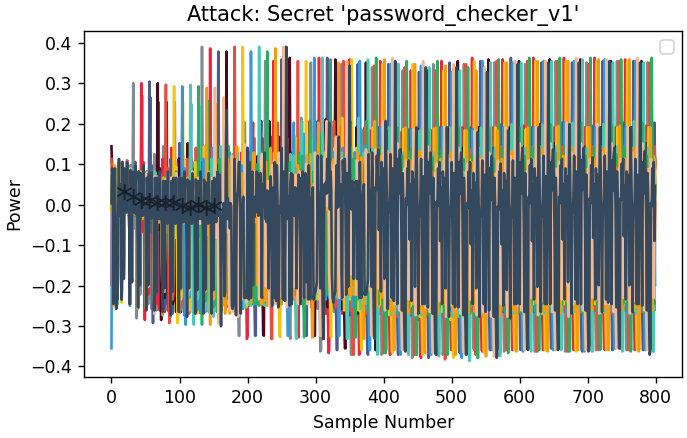

In [724]:
plt.figure(figsize=(5.5, 3.5), constrained_layout=True)

# list for colors
rbg = ['#7F8C8D', '#EF233C', '#4E598C', '#450920', '#E74C3C', 
       '#F1C40F', '#3498DB', '#48C9B0', '#27AE60', '#F39C12', 
       '#EDBB99', '#34495E', '#CCCCFF']

plt.title("Attack: Secret 'password_checker_v1'")     
plt.xlabel("Sample Number")  # adds x-axis label
plt.ylabel("Power")          # adds y-axis label
plt.yticks(np.arange(-1.0 - 1, 1.0 + 1, step=0.1))
plt.legend()

for i in range(len(trace_list)):
    plt.plot(trace_list[i], color=rbg[i])
    
x = 0
for trace in trace_list:
    plt.annotate('*', 
                 xy = (pos_list[x], trace[pos_list[x]]), 
                 xytext = (pos_list[x], trace[pos_list[x]]),
                 size=20,
                 color='#17202A',
                 ha='center', va="center")
    x = x + 1
    


# saves the plot
plt.savefig("../Figures/attack_cmd_a.pdf")

# show the plot on your screen
plt.show()

### Test with cmd='b'

Find the password with `password_checker_v2`

__Complete missing parts__

In [727]:
# "attack-CWNANO.hex"; cmd='b'
password, trace_list, pos_list = find_password('b')

print("Password:", password)

# Verify password
msg = check_password(password,'b')
print(f"Confirm {password}: {msg}")
# # do not change these lines below:
assert msg == "ACCESS GRANTED"
print("✔️ OK to continue!")

Password: TimingSCAszi
Confirm TimingSCAszi: ACCESS GRANTED
✔️ OK to continue!


Plot all the traces stored in "trace_list" and annotate where each trace starts to differ or with significant peaks (use "pos_list")

<IPython.core.display.Javascript object>


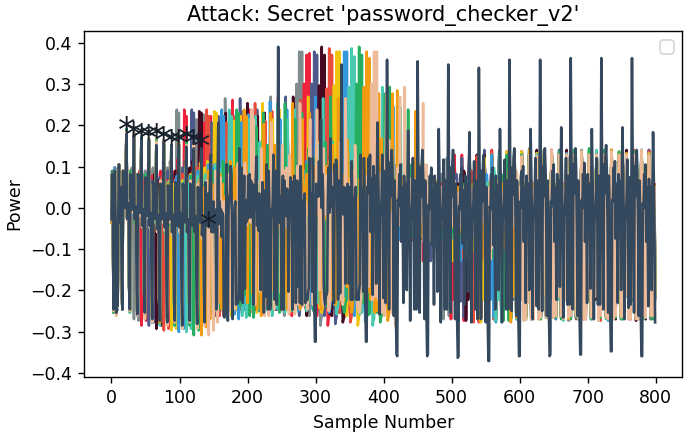

In [728]:
plt.figure(figsize=(5.5, 3.5), constrained_layout=True)

# list for colors
rbg = ['#7F8C8D', '#EF233C', '#4E598C', '#450920', '#E74C3C', 
       '#F1C40F', '#3498DB', '#48C9B0', '#27AE60', '#F39C12', 
       '#EDBB99', '#34495E', '#CCCCFF']

plt.title("Attack: Secret 'password_checker_v2'")     
plt.xlabel("Sample Number")  # adds x-axis label
plt.ylabel("Power")          # adds y-axis label
plt.yticks(np.arange(-1.0 - 1, 1.0 + 1, step=0.1))
plt.legend()

for i in range(len(trace_list)):
    plt.plot(trace_list[i], color=rbg[i])
    
x = 0




for trace in trace_list:
    plt.annotate('*', 
                 xy = (pos_list[x], trace[pos_list[x]]), 
                 xytext = (pos_list[x], trace[pos_list[x]]),
                 size=20,
                 color='#17202A',
                 ha='center', va="center")
    x = x + 1
    


# saves the plot
plt.savefig("../Figures/attack_cmd_b.pdf")

# show the plot on your screen
plt.show()

# Attempting to Attack Your Countermeasure

After you successfully attacked the password checkers in "attack-CWNANO.hex" file and identified the secret password, then now apply some countermeasures.

* Resuse the same "training.c" file. Open it and make a copy of either function: `password_checker_v1` or `password_checker_v2` (whichever you prefer). Rename the new function to `password_checker_v3`.
    
* Modify the `password_checker_v3` with a countermeasure that prevents your full password attack.

* Add this new function callback in the `main` method, using simpleserial parameters `'c'`.

* Retry the same full password attack on this improved password checker. It should thwart your attack in previous parts. Save outputs showing the waveforms you have identified as belonging to the countermeasure password checking routine.

Use the same `"USFCSE"` password as the other password checkers in "training.c"

First, you need to recomplie "training.c" as you did in section 1.1:

In [766]:
%%bash
cd ../Firmware
make PLATFORM=CWNANO CRYPTO_TARGET=NONE

SS_VER set to SS_VER_1_1
make clean_objs .dep 
make[1]: Entering directory '/home/phs/Desktop/phs-labs/PHS-Lab-05/Firmware'
SS_VER set to SS_VER_1_1

+--------------------------------------------------------

Removing old files
rm -f -- training-CWNANO.hex
rm -f -- training-CWNANO.elf
rm -f -- training-CWNANO.map
rm -f -- objdir-CWNANO/*.o
rm -f -- objdir-CWNANO/*.lst
rm -f -- training.s simpleserial.s stm32f0_hal_nano.s stm32f0_hal_lowlevel.s
rm -f -- training.d simpleserial.d stm32f0_hal_nano.d stm32f0_hal_lowlevel.d
rm -f -- training.i simpleserial.i stm32f0_hal_nano.i stm32f0_hal_lowlevel.i
make[1]: '.dep' is up to date.
make[1]: Leaving directory '/home/phs/Desktop/phs-labs/PHS-Lab-05/Firmware'
make begin gccversion build sizeafter
make[1]: Entering directory '/home/phs/Desktop/phs-labs/PHS-Lab-05/Firmware'
SS_VER set to SS_VER_1_1

+--------------------------------------------------------

Welcome to another exciting ChipWhisperer target build!!


arm-none-eabi-gcc (15:10.3-2021.

+--------------------------------------------------------
+ Output File: training-CWNANO.hex
+--------------------------------------------------------
make[1]: Leaving directory '/home/phs/Desktop/phs-labs/PHS-Lab-05/Firmware'


The, re-program the microcontroller with the new generated "training-CWNANO" hex file as you did in section 1.1"

In [767]:
prog = cw.programmers.STM32FProgrammer
fw_path = '../Firmware/training-CWNANO.hex'
cw.program_target(scope, prog, fw_path)

print("✔️ OK to continue!")

Serial baud rate = 115200
Detected known STMF32: STM32F04xxx
Extended erase (0x44), this can take ten seconds or more
Attempting to program 13867 bytes at 0x8000000
STM32F Programming flash...
STM32F Reading flash...
Verified flash OK, 13867 bytes
Serial baud rate = 38400
✔️ OK to continue!


## Verify new password checker with countermeasure

First, verify correctness of your `password_checker_v3`. Pass the correct password "USFCSE" to see if it grants access as it should rather than by default always deny access.

__Complete missing parts__

In [768]:
# Should print start-up test from the device
reset_target()
print(readall_target())
print("✔️ OK to continue!")

*****Safe-o-matic 3000 Booting...
Aligning bits........[DONE]
Checking Cesium RNG..[DONE]
Masquerading flash...[DONE]
Decrypting database..[DONE]


Please enter password to continue: 
✔️ OK to continue!


In [769]:
# Pass the correct password (hardcoded) for cmd='c'
msg = check_password("USFCSE",'c')
print(f"Confirm USFCSE: {msg}")

# do not change these lines below:
assert msg == "ACCESS GRANTED"
print("✔️ OK to continue!")

Confirm USFCSE: ACCESS GRANTED
✔️ OK to continue!


Now, pass an incorrect password to see if it denies access as it should rather than by default always grant access.

__Complete missing parts__

In [770]:
# Pass an incorrect password (hardcoded) for cmd='c'
msg = check_password('phslab','c')
print(f"Confirm USFCSE: {msg}")

# do not change these lines below:
assert msg == "WRONG PASSWORD"
print("✔️ OK to continue!")

Confirm USFCSE: WRONG PASSWORD
✔️ OK to continue!


## Attempt attack on countermeasure

Attempt to attack `password_checker_v3` with your same full password attack.

__Complete missing parts__

In [760]:
# "training-CWNANO.hex"; cmd='c'

passd, trace_list, pos_list = find_password('c')
print(passd)
    

print("Password:", passd)

# Verify password
msg = check_password(passd,'c')
print(f"Confirm {passd}: {msg}")


# do not change these lines below:
assert msg == "WRONG PASSWORD"
print("✔️ OK to continue!")

ABAAAAAAAABAAAAA
Password: ABAAAAAAAABAAAAA
Confirm ABAAAAAAAABAAAAA: WRONG PASSWORD
✔️ OK to continue!


Plot all the traces stored in "trace_list" and annotate where each trace starts to differ or with significant peaks (use "pos_list")

<IPython.core.display.Javascript object>


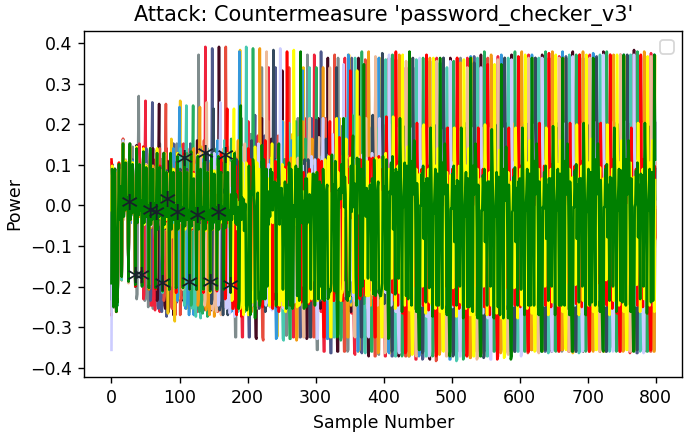

In [741]:
plt.figure(figsize=(5.5, 3.5), constrained_layout=True)

# list for colors
rbg = ['#7F8C8D', '#EF233C', '#4E598C', '#450920', '#E74C3C', 
       '#F1C40F', '#3498DB', '#48C9B0', '#27AE60', '#F39C12', 
       '#EDBB99', '#34495E', '#CCCCFF','red','yellow','green']

plt.title("Attack: Countermeasure 'password_checker_v3'")     
plt.xlabel("Sample Number")  # adds x-axis label
plt.ylabel("Power")          # adds y-axis label
plt.yticks(np.arange(-1.0 - 1, 1.0 + 1, step=0.1))
plt.legend()

for i in range(len(trace_list)):
    plt.plot(trace_list[i], color=rbg[i])
    
x = 0
for trace in trace_list:
    plt.annotate('*', 
                 xy = (pos_list[x], trace[pos_list[x]]), 
                 xytext = (pos_list[x], trace[pos_list[x]]),
                 size=20,
                 color='#17202A',
                 ha='center', va="center")
    x = x + 1
    


# saves the plot
plt.savefig("../Figures/train_cmd_c.pdf")

# show the plot on your screen
plt.show()

# Diconnect Scope/Target

Disconnect the CW's scope and target:

In [657]:
scope.dis()
target.dis()